In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the names in the dataset
words = open('names.txt',  'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
#building the vocabulary of characters and mapping them to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [163]:
#build datasets

block_size = 3 # context length
vocab_size = 27 # number of chars in our char vocabulary (total possible outputs)

def build_dataset(words):
    #dataset prep
    X, Y = [], []  
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [164]:
g = torch.Generator().manual_seed(2147483647) #for reproducibility

n_embed = 10 # dimensions of the embedding vectors corresponding to each of the character
n_hidden = 200 # number of neurons in the hidden tanh layer

#initialisation
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3) / ((block_size * n_embed)**2) #gain/sqroot(inputs) (kaiming init)    # 0.2 #very very low to avoid hpreact taking extreme values leading to tanh being 1/ -1 and the on backprop becasue of 1- t**2 differential, no gradient descent will change the value of the neuron and these are effectively dead neurons
#b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # same as above reason # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
W2 = torch.rand((n_hidden, vocab_size),            generator=g) * 0.01 #(5/3) / ((n_hidden)**2) #gain/sqroot(inputs) (kaiming init) # 0.01 # same reason as below, trying to make logits all as small (close to zero) as possbile to have a good starting point
b2 = torch.rand(vocab_size,                        generator=g) * 0 # zero at initialisation because we want logits to be as small/ close to zera as possible (otherwise iteration 1 is way off that a smooth distribution loss)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [165]:
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):
    
    #minibatch - samples that we want to train in this pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #batch_size, block_size (3) , embedding dimensions (10)
    embcat = emb.view(-1, block_size * n_embed) #concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias  #hidden layer pre activation
    #batch normalisation
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias

    #updating running bn mean and std
    with torch.no_grad(): 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact) #hidden layer 
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backard pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-0.75 if i < max_steps/2 else 10**-1.75 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2969
  10000/ 200000: 2.1334
  20000/ 200000: 2.2985
  30000/ 200000: 2.0130
  40000/ 200000: 2.1626
  50000/ 200000: 2.1163
  60000/ 200000: 2.5517
  70000/ 200000: 2.2950
  80000/ 200000: 2.3961
  90000/ 200000: 2.3794
 100000/ 200000: 2.0337
 110000/ 200000: 2.2268
 120000/ 200000: 1.8882
 130000/ 200000: 2.1793
 140000/ 200000: 1.9140
 150000/ 200000: 2.0697
 160000/ 200000: 2.0884
 170000/ 200000: 2.1666
 180000/ 200000: 2.1801
 190000/ 200000: 1.8457


In [155]:
hpreact.mean(0, keepdims=True).shape
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

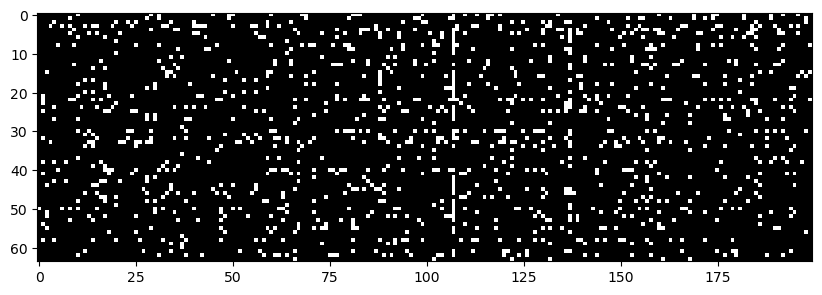

In [156]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

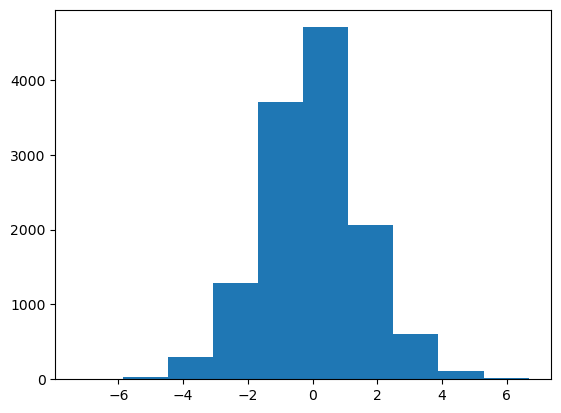

In [157]:
plt.hist(hpreact.view(-1).tolist());

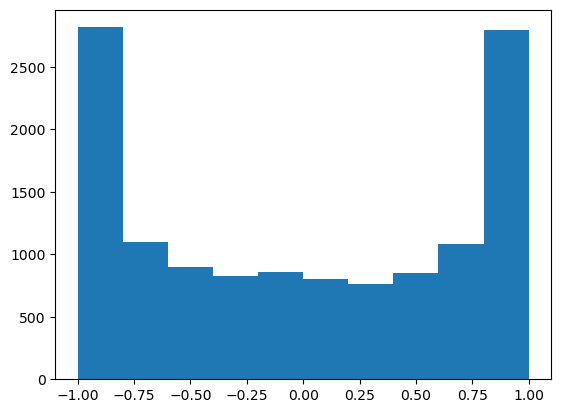

In [158]:
plt.hist(h.view(-1).tolist());

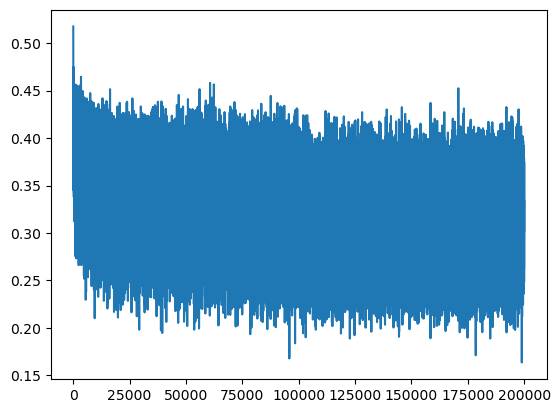

In [159]:
plt.plot(lossi)

In [160]:
# calibrate the batch norm at the end of training to be able to accept single inputs during inference as we are not passing normalised batchess during trainng
with torch.no_grad():
    #pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    #measure std deviation / mean across the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [161]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) #concat into N(total samples), block_size * n_embed
    hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
    #batch normalisation
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0346548557281494
dev 2.1010234355926514


In [162]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initializing with . . .
    while True:
        #forward pass
        emb = C[torch.tensor([context])] #(1, block_size, n_embed)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
        #batch normalisation
        hpreact = bngain * (hpreact - bnmean)/ bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        #sample from the distribtion
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        #shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        #if we encounted a special character
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word

carmah.
amillivi.
kimri.
reigh.
halaysie.
rahnel.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jord.
quintis.
lilea.
jadiquinte.
madiarinix.
kael.
druan.
edde.


tensor(0.0023) tensor(0.9922)
tensor(0.0064) tensor(1.0012)


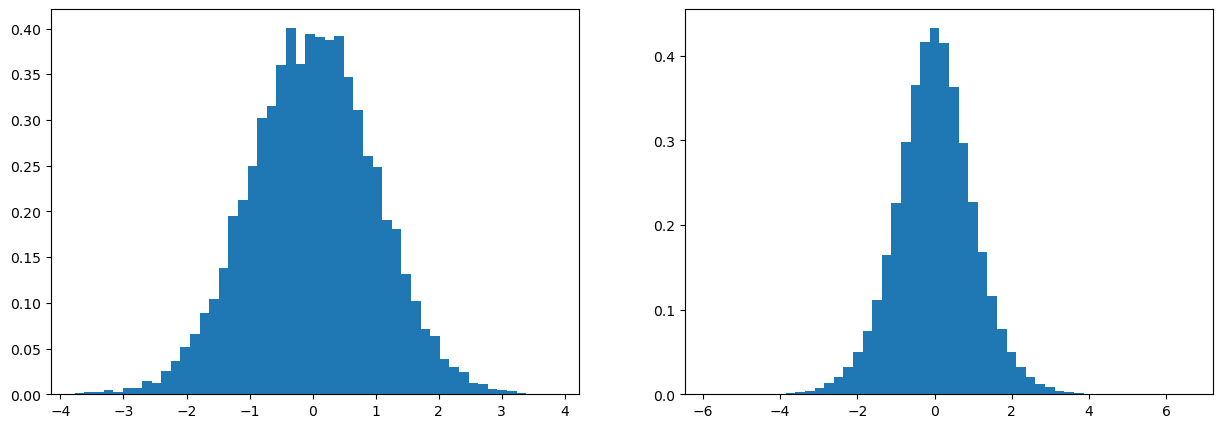

In [78]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);